In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



In [67]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [68]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [69]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [70]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [71]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,25,30,31)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [72]:
x_train.shape

(11395, 60, 80, 3)

In [73]:
# tlen = len(xtemp[0])-2 +len(xtemp[1])-2+len(xtemp[2])+len(xtemp[3]) #remove 2 samples from 24
# x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
# x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
# x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

tlen = len(xtemp[0])-2 +len(xtemp[1])-3+len(xtemp[2])+len(xtemp[3]) #remove 2 samples from 24 and 3 from 25
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
xrun = len(xtemp[0])-2
x_train[:xrun,:,:,:] = xtemp[0][:xrun,:,:,:]
xrun1 = xrun + len(xtemp[1])-3
x_train[xrun:xrun1,:,:,:]=xtemp[1][:xrun1-xrun,:,:,:]
xrun2 = xrun1 + len(xtemp[2])
x_train[xrun1:xrun2,:,:,:] = xtemp[2][:xrun2-xrun1,:,:,:]
xrun3 = xrun2 + len(xtemp[2])
x_train[xrun2:xrun3,:,:,:] = xtemp[2][:xrun3-xrun2,:,:,:]

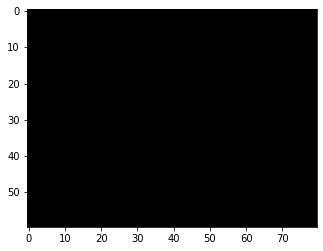

In [74]:
plt.imshow(x_train[-2])


## model.summary()

# read fdss data

In [75]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [76]:
# tmpdata.head()

# Read Output Data


In [77]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,25,30,31)
date = ('11_15_2020','11_19_2020','11_24_2020','11_24_2020')
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])-2 +len(y_gt[1])-3+len(y_gt[2])+len(y_gt[3]) #remove 2 samples from 24 and 3 from 25
y_train = np.zeros((tlen,1))
xrun = len(y_gt[0])-2
y_train[:xrun] = y_gt[0][:xrun]
xrun1 = xrun + len(y_gt[1])-3
y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
xrun2 = xrun1 + len(y_gt[2])
y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
xrun3 = xrun2 + len(y_gt[2])
y_train[xrun2:xrun3] = y_gt[2][:xrun3-xrun2]

In [78]:
print(len(y_gt[2]))
print(len(y_gt[0])-2+len(y_gt[1])+len(y_gt[1]))
print(len(y_gt[0])-2+len(y_gt[1])+len(y_gt[1])+len(y_gt[2]))

5466
42087
47553


In [79]:
# Obtain X and Y data
# x_train.shape
# xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
# yframe = pd.DataFrame(data=y_train)

# TheData = pd.concat([xtrainnew,yframe],axis=1) #only contains video data
print(x_train.shape)
print(y_train.shape)

(44275, 60, 80, 3)
(44276, 1)


In [80]:
print(xtemp[0].shape)
print(y_gt[0].shape)
print(xtemp[1].shape)
print(y_gt[1].shape)

(12751, 60, 80, 3)
(12751, 1)
(14668, 60, 80, 3)
(14669, 1)


In [81]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [82]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [83]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [84]:
sc_y = StandardScaler()

In [85]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [86]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [99]:
x_train.shape

(44275, 60, 80, 3)

# Regress using Neural Network

In [88]:
np.min(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

0.0

In [91]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.2
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
# # model_cnn = BatchNormalization()(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# # model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 80, 16)        448       
_________________________________________________________________
activation_37 (Activation)   (None, 60, 80, 16)        0         
_________________________________________________________________
average_pooling2d_25 (Averag (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 40, 32)        4640      
_________________________________________________________________
activation_38 (Activation)   (None, 30, 40, 32)        0         
_________________________________________________________________
average_pooling2d_26 (Averag (None, 15, 20, 32)        0   

In [92]:
epochs = int(30000)
batch_size = 256
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 35420 samples, validate on 8855 samples
Epoch 1/30000
 - 5s - loss: 0.5990 - mse: 0.9679 - mae: 0.5990 - val_loss: 0.5871 - val_mse: 0.9355 - val_mae: 0.5871
Epoch 2/30000
 - 4s - loss: 0.5854 - mse: 0.9241 - mae: 0.5854 - val_loss: 0.5784 - val_mse: 0.9032 - val_mae: 0.5784
Epoch 3/30000
 - 4s - loss: 0.5678 - mse: 0.8682 - mae: 0.5678 - val_loss: 0.5612 - val_mse: 0.8572 - val_mae: 0.5612
Epoch 4/30000
 - 4s - loss: 0.5504 - mse: 0.8254 - mae: 0.5504 - val_loss: 0.5473 - val_mse: 0.8173 - val_mae: 0.5473
Epoch 5/30000
 - 4s - loss: 0.5351 - mse: 0.7936 - mae: 0.5351 - val_loss: 0.5267 - val_mse: 0.7792 - val_mae: 0.5267
Epoch 6/30000
 - 4s - loss: 0.5207 - mse: 0.7591 - mae: 0.5207 - val_loss: 0.5168 - val_mse: 0.7525 - val_mae: 0.5168
Epoch 7/30000
 - 4s - loss: 0.5073 - mse: 0.7178 - mae: 0.5073 - val_loss: 0.4979 - val_mse: 0.6805 - val_mae: 0.4979
Epoch 8/30000
 - 4s - loss: 0.4901 - mse: 0.6455 - mae: 0.4901 - val_loss: 0.4817 - val_mse: 0.6122 - val_mae: 0.4817
Epoch 9

Epoch 70/30000
 - 4s - loss: 0.2449 - mse: 0.2135 - mae: 0.2449 - val_loss: 0.2849 - val_mse: 0.2810 - val_mae: 0.2849
Epoch 71/30000
 - 4s - loss: 0.2443 - mse: 0.2129 - mae: 0.2443 - val_loss: 0.2907 - val_mse: 0.2817 - val_mae: 0.2907
Epoch 72/30000
 - 4s - loss: 0.2435 - mse: 0.2108 - mae: 0.2435 - val_loss: 0.2833 - val_mse: 0.2740 - val_mae: 0.2833
Epoch 73/30000
 - 4s - loss: 0.2437 - mse: 0.2130 - mae: 0.2437 - val_loss: 0.2889 - val_mse: 0.2787 - val_mae: 0.2889
Epoch 74/30000
 - 4s - loss: 0.2396 - mse: 0.2073 - mae: 0.2396 - val_loss: 0.2869 - val_mse: 0.2782 - val_mae: 0.2869
Epoch 75/30000
 - 4s - loss: 0.2388 - mse: 0.2042 - mae: 0.2388 - val_loss: 0.2815 - val_mse: 0.2730 - val_mae: 0.2815
Epoch 76/30000
 - 4s - loss: 0.2381 - mse: 0.2035 - mae: 0.2381 - val_loss: 0.2811 - val_mse: 0.2690 - val_mae: 0.2811
Epoch 77/30000
 - 4s - loss: 0.2347 - mse: 0.1985 - mae: 0.2347 - val_loss: 0.2830 - val_mse: 0.2715 - val_mae: 0.2830
Epoch 78/30000
 - 4s - loss: 0.2348 - mse: 0.199

Epoch 139/30000
 - 4s - loss: 0.1882 - mse: 0.1371 - mae: 0.1882 - val_loss: 0.2562 - val_mse: 0.2388 - val_mae: 0.2562
Epoch 140/30000
 - 4s - loss: 0.1870 - mse: 0.1352 - mae: 0.1870 - val_loss: 0.2523 - val_mse: 0.2331 - val_mae: 0.2523
Epoch 141/30000
 - 4s - loss: 0.1867 - mse: 0.1348 - mae: 0.1867 - val_loss: 0.2532 - val_mse: 0.2365 - val_mae: 0.2532
Epoch 142/30000
 - 4s - loss: 0.1877 - mse: 0.1376 - mae: 0.1877 - val_loss: 0.2499 - val_mse: 0.2327 - val_mae: 0.2499
Epoch 143/30000
 - 4s - loss: 0.1866 - mse: 0.1346 - mae: 0.1866 - val_loss: 0.2517 - val_mse: 0.2317 - val_mae: 0.2517
Epoch 144/30000
 - 4s - loss: 0.1872 - mse: 0.1351 - mae: 0.1872 - val_loss: 0.2446 - val_mse: 0.2256 - val_mae: 0.2446
Epoch 145/30000
 - 4s - loss: 0.1872 - mse: 0.1361 - mae: 0.1872 - val_loss: 0.2498 - val_mse: 0.2352 - val_mae: 0.2498
Epoch 146/30000
 - 4s - loss: 0.1853 - mse: 0.1345 - mae: 0.1853 - val_loss: 0.2523 - val_mse: 0.2309 - val_mae: 0.2523
Epoch 147/30000
 - 4s - loss: 0.1851 - m

Epoch 208/30000
 - 4s - loss: 0.1660 - mse: 0.1118 - mae: 0.1660 - val_loss: 0.2417 - val_mse: 0.2233 - val_mae: 0.2417
Epoch 209/30000
 - 4s - loss: 0.1654 - mse: 0.1122 - mae: 0.1654 - val_loss: 0.2349 - val_mse: 0.2199 - val_mae: 0.2349
Epoch 210/30000
 - 4s - loss: 0.1666 - mse: 0.1132 - mae: 0.1666 - val_loss: 0.2355 - val_mse: 0.2166 - val_mae: 0.2355
Epoch 211/30000
 - 4s - loss: 0.1649 - mse: 0.1112 - mae: 0.1649 - val_loss: 0.2332 - val_mse: 0.2145 - val_mae: 0.2332
Epoch 212/30000
 - 4s - loss: 0.1647 - mse: 0.1105 - mae: 0.1647 - val_loss: 0.2383 - val_mse: 0.2186 - val_mae: 0.2383
Epoch 213/30000
 - 4s - loss: 0.1668 - mse: 0.1117 - mae: 0.1668 - val_loss: 0.2365 - val_mse: 0.2179 - val_mae: 0.2365
Epoch 214/30000
 - 4s - loss: 0.1641 - mse: 0.1118 - mae: 0.1641 - val_loss: 0.2328 - val_mse: 0.2102 - val_mae: 0.2328
Epoch 215/30000
 - 4s - loss: 0.1644 - mse: 0.1114 - mae: 0.1644 - val_loss: 0.2319 - val_mse: 0.2107 - val_mae: 0.2319
Epoch 216/30000
 - 4s - loss: 0.1644 - m

Epoch 277/30000
 - 4s - loss: 0.1518 - mse: 0.0980 - mae: 0.1518 - val_loss: 0.2284 - val_mse: 0.2059 - val_mae: 0.2284
Epoch 278/30000
 - 4s - loss: 0.1521 - mse: 0.0983 - mae: 0.1521 - val_loss: 0.2318 - val_mse: 0.2097 - val_mae: 0.2318
Epoch 279/30000
 - 4s - loss: 0.1528 - mse: 0.0978 - mae: 0.1528 - val_loss: 0.2318 - val_mse: 0.2142 - val_mae: 0.2318
Epoch 280/30000
 - 4s - loss: 0.1508 - mse: 0.0954 - mae: 0.1508 - val_loss: 0.2248 - val_mse: 0.2024 - val_mae: 0.2248
Epoch 281/30000
 - 4s - loss: 0.1500 - mse: 0.0951 - mae: 0.1500 - val_loss: 0.2305 - val_mse: 0.2112 - val_mae: 0.2305
Epoch 282/30000
 - 4s - loss: 0.1527 - mse: 0.0965 - mae: 0.1527 - val_loss: 0.2307 - val_mse: 0.2127 - val_mae: 0.2307
Epoch 283/30000
 - 4s - loss: 0.1511 - mse: 0.0955 - mae: 0.1511 - val_loss: 0.2344 - val_mse: 0.2169 - val_mae: 0.2344
Epoch 284/30000
 - 4s - loss: 0.1518 - mse: 0.0963 - mae: 0.1518 - val_loss: 0.2270 - val_mse: 0.2088 - val_mae: 0.2270
Epoch 285/30000
 - 4s - loss: 0.1505 - m

Epoch 346/30000
 - 4s - loss: 0.1437 - mse: 0.0886 - mae: 0.1437 - val_loss: 0.2245 - val_mse: 0.1987 - val_mae: 0.2245
Epoch 347/30000
 - 4s - loss: 0.1424 - mse: 0.0865 - mae: 0.1424 - val_loss: 0.2251 - val_mse: 0.2061 - val_mae: 0.2251
Epoch 348/30000
 - 4s - loss: 0.1427 - mse: 0.0871 - mae: 0.1427 - val_loss: 0.2325 - val_mse: 0.2055 - val_mae: 0.2325
Epoch 349/30000
 - 4s - loss: 0.1426 - mse: 0.0861 - mae: 0.1426 - val_loss: 0.2216 - val_mse: 0.1985 - val_mae: 0.2216
Epoch 350/30000
 - 4s - loss: 0.1433 - mse: 0.0876 - mae: 0.1433 - val_loss: 0.2212 - val_mse: 0.1990 - val_mae: 0.2212
Epoch 351/30000
 - 4s - loss: 0.1422 - mse: 0.0868 - mae: 0.1422 - val_loss: 0.2235 - val_mse: 0.2042 - val_mae: 0.2235
Epoch 352/30000
 - 4s - loss: 0.1428 - mse: 0.0876 - mae: 0.1428 - val_loss: 0.2232 - val_mse: 0.2013 - val_mae: 0.2232
Epoch 353/30000
 - 4s - loss: 0.1426 - mse: 0.0864 - mae: 0.1426 - val_loss: 0.2254 - val_mse: 0.2036 - val_mae: 0.2254
Epoch 354/30000
 - 4s - loss: 0.1421 - m

Epoch 415/30000
 - 4s - loss: 0.1358 - mse: 0.0788 - mae: 0.1358 - val_loss: 0.2234 - val_mse: 0.2003 - val_mae: 0.2234
Epoch 416/30000
 - 4s - loss: 0.1356 - mse: 0.0795 - mae: 0.1356 - val_loss: 0.2218 - val_mse: 0.2005 - val_mae: 0.2218
Epoch 417/30000
 - 4s - loss: 0.1371 - mse: 0.0819 - mae: 0.1371 - val_loss: 0.2206 - val_mse: 0.2003 - val_mae: 0.2206
Epoch 418/30000
 - 4s - loss: 0.1360 - mse: 0.0803 - mae: 0.1360 - val_loss: 0.2333 - val_mse: 0.2081 - val_mae: 0.2333
Epoch 419/30000
 - 4s - loss: 0.1376 - mse: 0.0798 - mae: 0.1376 - val_loss: 0.2212 - val_mse: 0.1964 - val_mae: 0.2212
Epoch 420/30000
 - 4s - loss: 0.1348 - mse: 0.0783 - mae: 0.1348 - val_loss: 0.2240 - val_mse: 0.2000 - val_mae: 0.2240
Epoch 421/30000
 - 4s - loss: 0.1382 - mse: 0.0828 - mae: 0.1382 - val_loss: 0.2231 - val_mse: 0.1977 - val_mae: 0.2231
Epoch 422/30000
 - 4s - loss: 0.1359 - mse: 0.0792 - mae: 0.1359 - val_loss: 0.2190 - val_mse: 0.1986 - val_mae: 0.2190
Epoch 423/30000
 - 4s - loss: 0.1370 - m

Epoch 484/30000
 - 4s - loss: 0.1321 - mse: 0.0743 - mae: 0.1321 - val_loss: 0.2174 - val_mse: 0.1915 - val_mae: 0.2174
Epoch 485/30000
 - 4s - loss: 0.1320 - mse: 0.0741 - mae: 0.1320 - val_loss: 0.2192 - val_mse: 0.1955 - val_mae: 0.2192
Epoch 486/30000
 - 4s - loss: 0.1324 - mse: 0.0741 - mae: 0.1324 - val_loss: 0.2196 - val_mse: 0.1970 - val_mae: 0.2196
Epoch 487/30000
 - 4s - loss: 0.1319 - mse: 0.0723 - mae: 0.1319 - val_loss: 0.2169 - val_mse: 0.1952 - val_mae: 0.2169
Epoch 488/30000
 - 4s - loss: 0.1303 - mse: 0.0742 - mae: 0.1303 - val_loss: 0.2204 - val_mse: 0.1953 - val_mae: 0.2204
Epoch 489/30000
 - 4s - loss: 0.1289 - mse: 0.0705 - mae: 0.1289 - val_loss: 0.2172 - val_mse: 0.1925 - val_mae: 0.2172
Epoch 490/30000
 - 4s - loss: 0.1299 - mse: 0.0725 - mae: 0.1299 - val_loss: 0.2202 - val_mse: 0.1955 - val_mae: 0.2202
Epoch 491/30000
 - 4s - loss: 0.1313 - mse: 0.0723 - mae: 0.1313 - val_loss: 0.2178 - val_mse: 0.1939 - val_mae: 0.2178
Epoch 492/30000
 - 4s - loss: 0.1312 - m

Epoch 553/30000
 - 4s - loss: 0.1269 - mse: 0.0683 - mae: 0.1269 - val_loss: 0.2194 - val_mse: 0.1970 - val_mae: 0.2194
Epoch 554/30000
 - 4s - loss: 0.1265 - mse: 0.0684 - mae: 0.1265 - val_loss: 0.2173 - val_mse: 0.1940 - val_mae: 0.2173
Epoch 555/30000
 - 4s - loss: 0.1270 - mse: 0.0696 - mae: 0.1270 - val_loss: 0.2172 - val_mse: 0.1960 - val_mae: 0.2172
Epoch 556/30000
 - 4s - loss: 0.1282 - mse: 0.0692 - mae: 0.1282 - val_loss: 0.2159 - val_mse: 0.1934 - val_mae: 0.2159


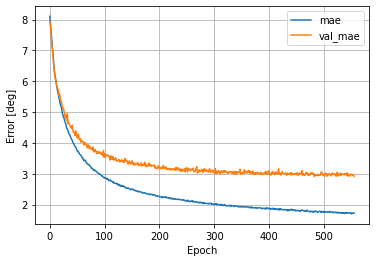

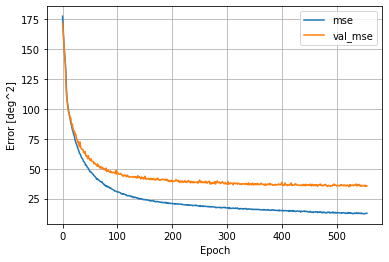

In [93]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

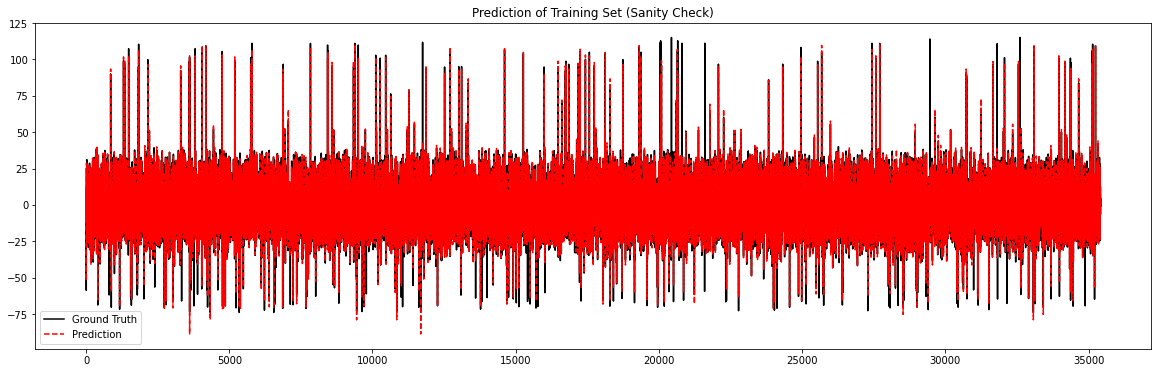

Average error is -0.00 degrees
Root Mean Squared Error is 1.09 degrees
Mean Absolute Error is 1.09 degrees


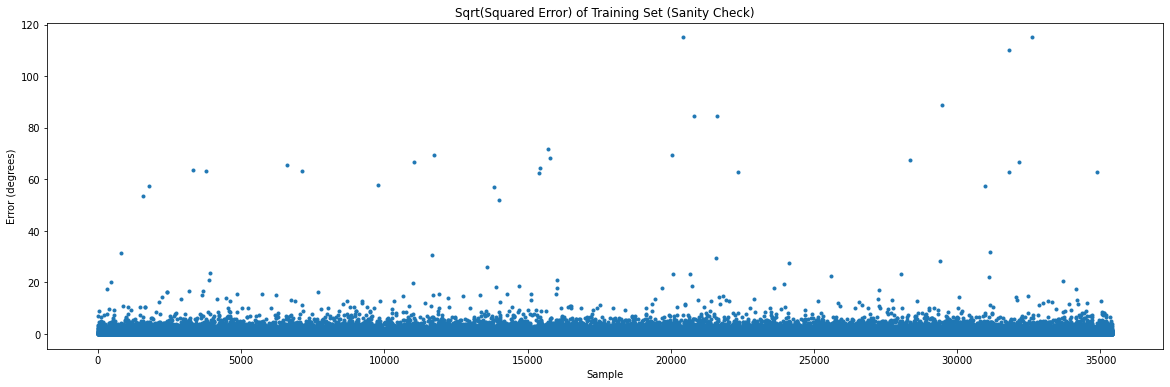

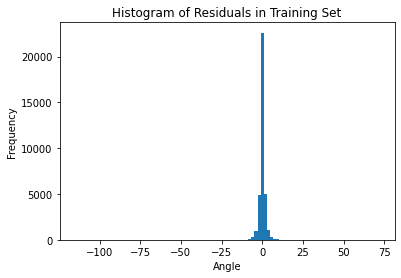

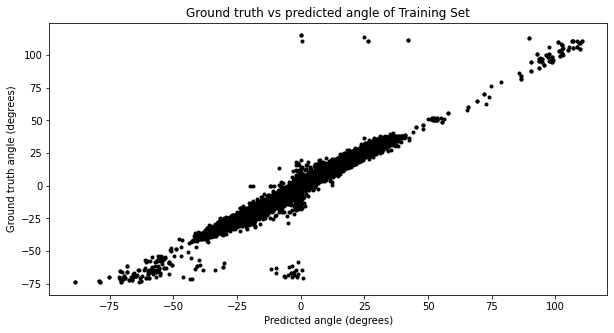

In [94]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

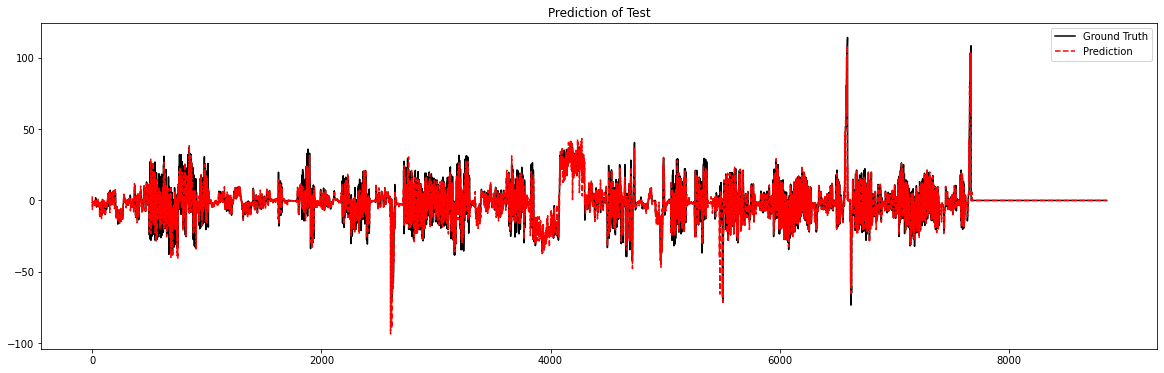

Average error is -0.19 degrees
Root Mean Squared Error is 2.92 degrees
Mean Absolute Error is 2.92 degrees


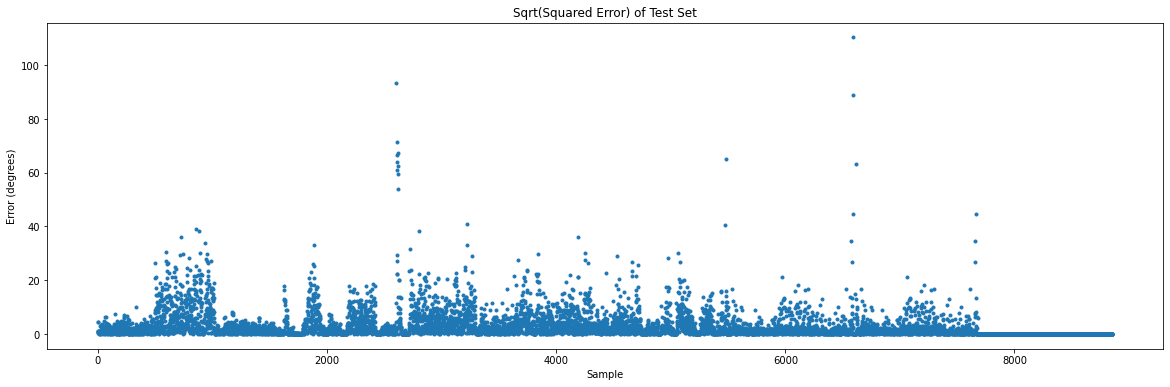

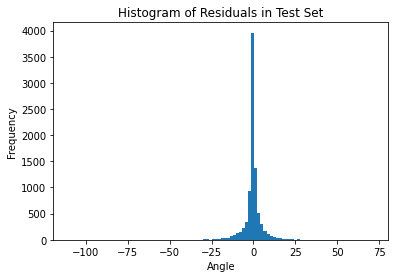

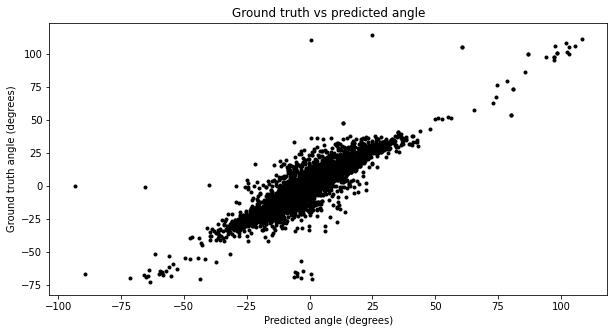

In [95]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [96]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthmodelparam_cnn3v12.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthmodel_cnn3v12.h5') 